In [175]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.spatial import distance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)

### Dataset dan Analisis Deskriptif

In [176]:
data = pd.read_csv('air_data.csv')

data['categori_encoded'] = data['categori'].map({
    'BAIK': 0, 
    'SEDANG': 1, 
    'TIDAK SEHAT': 2, 
    'SANGAT TIDAK SEHAT': 3, 
    'BERBAHAYA': 4
})

data = data.drop(columns=["tanggal", "stasiun", "max", "critical", "pm25", "categori"])

data

,pm10,so2,co,o3,no2,categori_encoded
0,60.0,4.0,73.0,27.0,14.0,1
1,32.0,2.0,16.0,33.0,9.0,0
2,27.0,2.0,19.0,20.0,9.0,0
3,22.0,2.0,16.0,15.0,6.0,0
4,25.0,2.0,17.0,15.0,8.0,0
...,...,...,...,...,...,...
4620,55.0,43.0,15.0,15.0,25.0,1
4621,54.0,56.0,13.0,27.0,16.0,1
4622,62.0,45.0,15.0,29.0,34.0,1
4623,71.0,30.0,19.0,22.0,14.0,2


In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pm10              4466 non-null   float64
 1   so2               4607 non-null   float64
 2   co                4618 non-null   float64
 3   o3                4621 non-null   float64
 4   no2               4618 non-null   float64
 5   categori_encoded  4625 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 216.9 KB


In [178]:
data.describe()

,pm10,so2,co,o3,no2,categori_encoded
count,4466.000000,4607.000000,4618.000000,4621.000000,4618.000000,4625.000000
mean,65.086879,28.183851,30.263534,86.586670,18.120832,1.366486
std,19.243150,13.822107,13.640344,50.295879,8.451605,0.664830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,18.000000,21.000000,51.000000,13.000000,1.000000
50%,64.000000,27.000000,29.000000,78.000000,17.000000,1.000000
75%,75.000000,34.000000,37.000000,110.000000,21.000000,2.000000
max,179.000000,126.000000,134.000000,314.000000,134.000000,4.000000


In [179]:
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
pm10                159
so2                  18
co                    7
o3                    4
no2                   7
categori_encoded      0
dtype: int64


In [180]:
def mahalanobis_impute(data):
    mean_values = data.mean()
    cov_matrix = data.cov()
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    for column in data.columns:
        if data[column].isnull().any():
            null_indices = data[data[column].isnull()].index

            for idx in null_indices:
                diff = data.loc[idx] - mean_values
                mahalanobis_dist = distance.mahalanobis(diff, np.zeros(len(mean_values)), inv_cov_matrix)
                data.loc[idx, column] = mean_values[column]
                
    return data

def preprocess_data(data):
    data = mahalanobis_impute(data)
    
    X = data.drop(columns=['categori_encoded'])
    y = data['categori_encoded']
    
    return X, y, X.columns


In [181]:
X, y, feature_names = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Deteksi Outliers

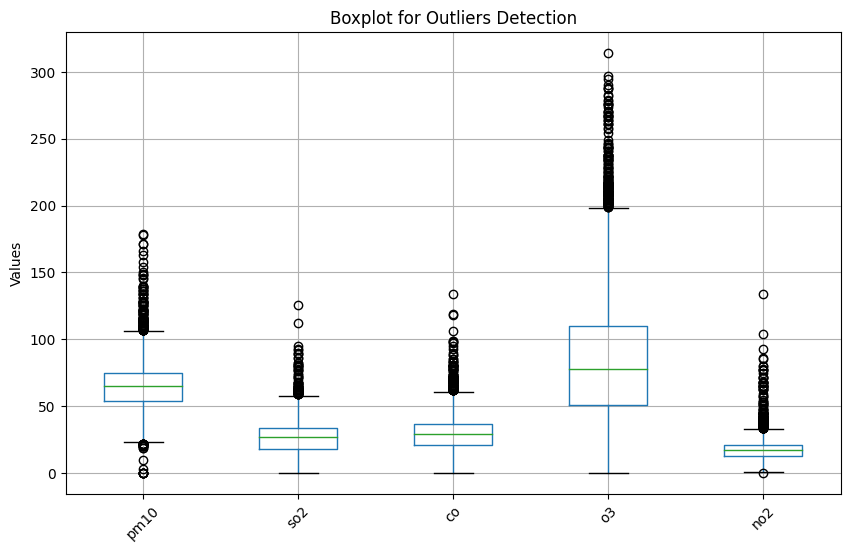

Outlier Information:
pm10: 166 outliers (Bounds: 22.5 - 106.5)
so2: 77 outliers (Bounds: -6.0 - 58.0)
co: 129 outliers (Bounds: -3.0 - 61.0)
o3: 203 outliers (Bounds: -37.5 - 198.5)
no2: 190 outliers (Bounds: 1.0 - 33.0)


In [182]:
X_df = pd.DataFrame(X, columns=feature_names)

numerical_columns = X_df.select_dtypes(include=[np.number]).columns
outlier_info = {}

for col in numerical_columns:
    Q1 = X_df[col].quantile(0.25)  # Kuartil pertama
    Q3 = X_df[col].quantile(0.75)  # Kuartil ketiga
    IQR = Q3 - Q1                  # Rentang antar-kuartil

    lower_bound = Q1 - 1.5 * IQR   # Batas bawah
    upper_bound = Q3 + 1.5 * IQR   # Batas atas

    # Outlier
    outliers = X_df[(X_df[col] < lower_bound) | (X_df[col] > upper_bound)]
    outlier_info[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': len(outliers)
    }

plt.figure(figsize=(10, 6))
X_df[numerical_columns].boxplot(vert=True)
plt.title("Boxplot for Outliers Detection")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

print("Outlier Information:")
for col, info in outlier_info.items():
    print(f"{col}: {info['num_outliers']} outliers (Bounds: {info['lower_bound']} - {info['upper_bound']})")

In [183]:
print("Distribusi kelas di y_train:")
print(y_train.value_counts())

print("Distribusi kelas di y_test:")
print(y_test.value_counts())

Distribusi kelas di y_train:
categori_encoded
1    2062
2    1269
0     216
3     152
4       1
Name: count, dtype: int64
Distribusi kelas di y_test:
categori_encoded
1    512
2    299
0     64
3     50
Name: count, dtype: int64


### Pencarian Parameter Terbaik

In [184]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [None, 5, 10, 20, 30]
}

gb_param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

rf_grid_search.fit(X, y)
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)
print(f"Best accuracy: {rf_grid_search.best_score_:.4f}")

gb_grid_search.fit(X, y)
print("\nBest parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)
print(f"Best accuracy: {gb_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/arielsulton/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest:
{'max_depth': 20, 'n_estimators': 100}
Best accuracy: 0.9194
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/arielsulton/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Best parameters for Gradient Boosting:
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50}
Best accuracy: 0.9178


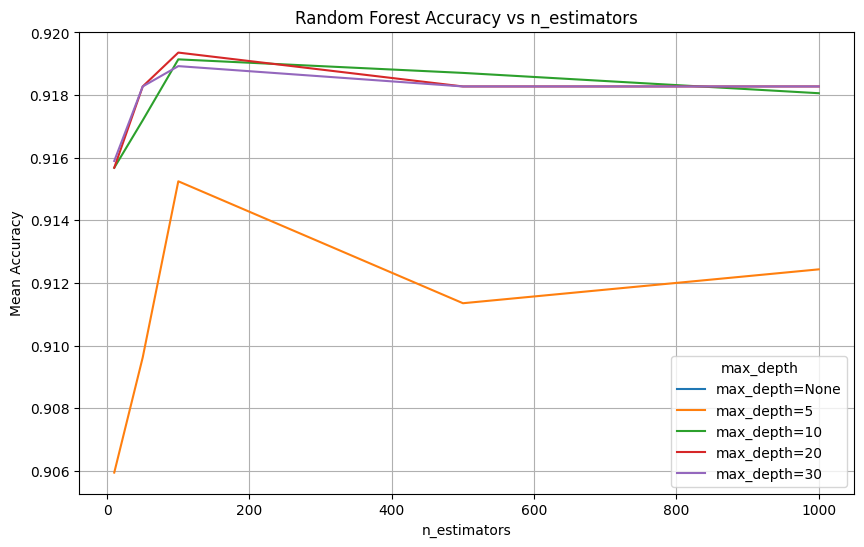

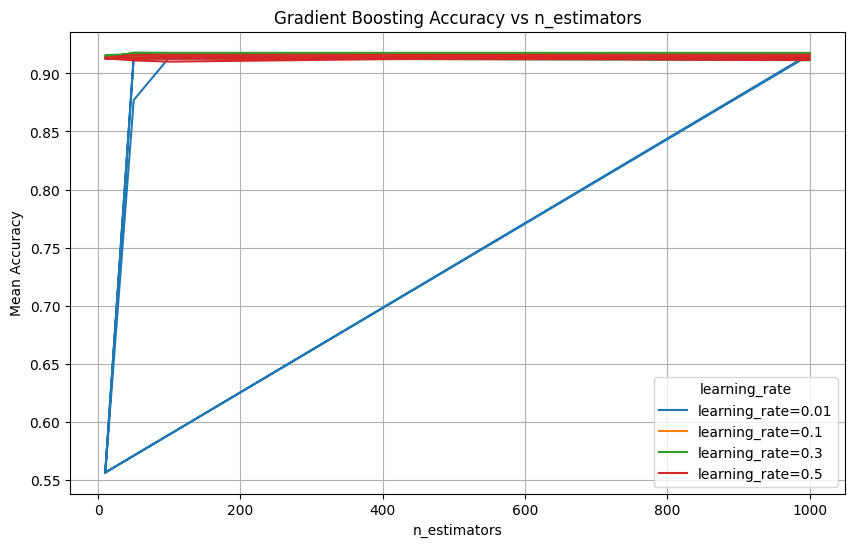

In [195]:
import matplotlib.pyplot as plt
import pandas as pd

# Random Forest: Ekstrak hasil tuning
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

plt.figure(figsize=(10, 6))
for depth in rf_param_grid['max_depth']:
    subset = rf_results[rf_results['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f"max_depth={depth}")

plt.title("Random Forest Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Mean Accuracy")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

# Gradient Boosting: Ekstrak hasil tuning
gb_results = pd.DataFrame(gb_grid_search.cv_results_)

plt.figure(figsize=(10, 6))
for lr in gb_param_grid['learning_rate']:
    subset = gb_results[gb_results['param_learning_rate'] == lr]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f"learning_rate={lr}")

plt.title("Gradient Boosting Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Mean Accuracy")
plt.legend(title="learning_rate")
plt.grid(True)
plt.show()

### Pemodelan RF dan GB

In [186]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"===== {model_name} Metrics =====")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_true, y_pred, average='weighted'))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }

In [187]:
def random_forest_model():
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=20,
        n_jobs=-1
    )
    
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
    print("Random Forest Cross-Validation Scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    
    rf_report = classification_report(y_test, y_pred_rf)
    rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")
    
    plt.figure(figsize=(10, 6))
    feature_imp = rf_classifier.feature_importances_
    indices = np.argsort(feature_imp)[::-1]
    
    plt.title("Feature Importances in Random Forest")
    plt.bar(range(len(feature_imp)), feature_imp[indices])
    plt.xticks(range(len(feature_imp)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()
    
    return rf_classifier, rf_report, rf_metrics

In [188]:
def gradient_boosting_model():
    gb_classifier = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.3,
        max_depth=10,
        random_state=42
    )
    
    cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=5)
    print("Gradient Boosting Cross-Validation Scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    
    gb_classifier.fit(X_train, y_train)
    y_pred_gb = gb_classifier.predict(X_test)
    
    gb_report = classification_report(y_test, y_pred_gb)
    gb_metrics = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
    
    return gb_classifier, gb_report, gb_metrics

In [189]:
def compare_models(rf_metrics, gb_metrics):
    print("\n===== Model Comparison =====")
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, list(rf_metrics.values()), width, label='Random Forest')
    plt.bar(x + width/2, list(gb_metrics.values()), width, label='Gradient Boosting')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/arielsulton/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Cross-Validation Scores: [0.96756757 0.96756757 0.96756757 0.95945946 0.97027027]
Mean CV Score: 0.9664864864864866
===== Random Forest Metrics =====
Accuracy:  0.9751351351351352
Precision:  0.975134323328498
Recall:  0.9751351351351352
F1 Score:  0.9751224053174996


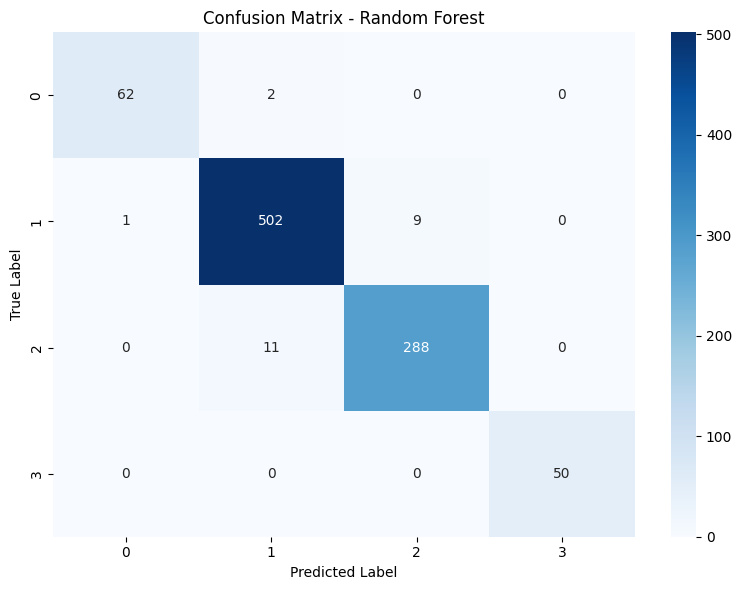

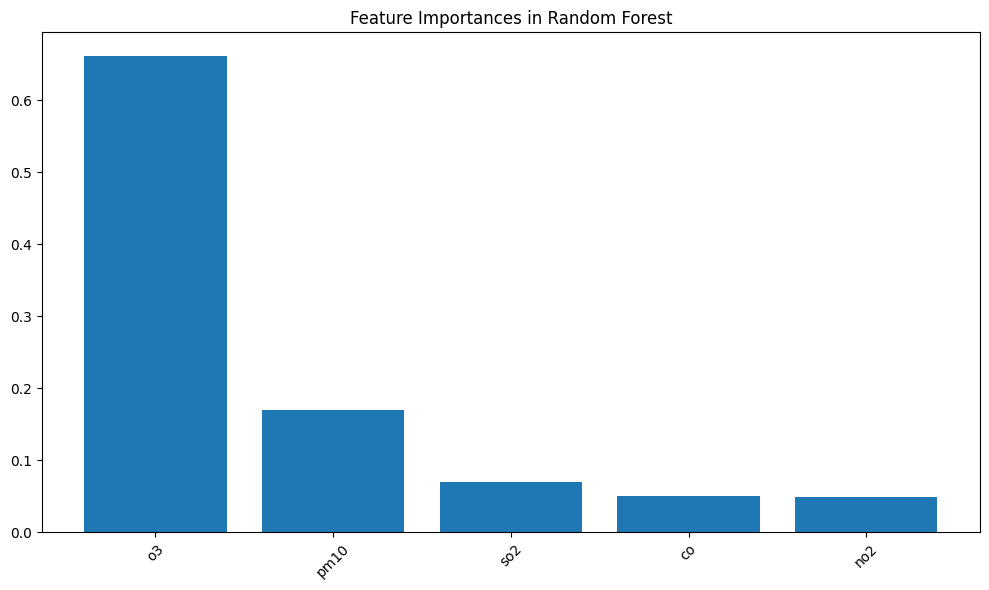

In [190]:
rf_model, rf_report, rf_metrics = random_forest_model()

/home/arielsulton/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Gradient Boosting Cross-Validation Scores: [0.96756757 0.97162162 0.97162162 0.97297297 0.97162162]
Mean CV Score: 0.971081081081081
===== Gradient Boosting Metrics =====
Accuracy:  0.9740540540540541
Precision:  0.9740688334117943
Recall:  0.9740540540540541
F1 Score:  0.9740542614307212


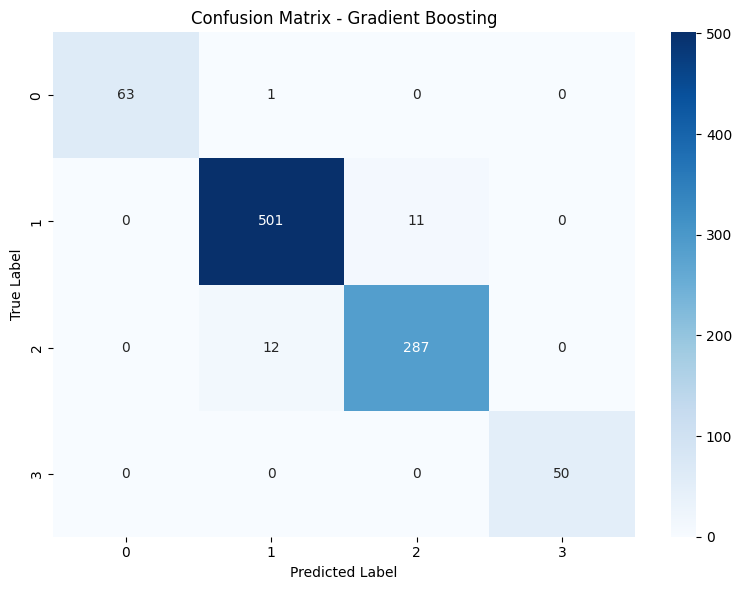

In [191]:
gb_model, gb_report, gb_metrics = gradient_boosting_model()

In [192]:
print("Random Forest Classification Report:")
print(rf_report)
print(rf_metrics)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        64
           1       0.97      0.98      0.98       512
           2       0.97      0.96      0.97       299
           3       1.00      1.00      1.00        50

    accuracy                           0.98       925
   macro avg       0.98      0.98      0.98       925
weighted avg       0.98      0.98      0.98       925

{'accuracy': 0.9751351351351352, 'precision': 0.975134323328498, 'recall': 0.9751351351351352, 'f1_score': 0.9751224053174996}


In [193]:
print("Gradient Boosting Classification Report:")
print(gb_report)
print(gb_metrics)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.97      0.98      0.98       512
           2       0.96      0.96      0.96       299
           3       1.00      1.00      1.00        50

    accuracy                           0.97       925
   macro avg       0.98      0.98      0.98       925
weighted avg       0.97      0.97      0.97       925

{'accuracy': 0.9740540540540541, 'precision': 0.9740688334117943, 'recall': 0.9740540540540541, 'f1_score': 0.9740542614307212}



===== Model Comparison =====


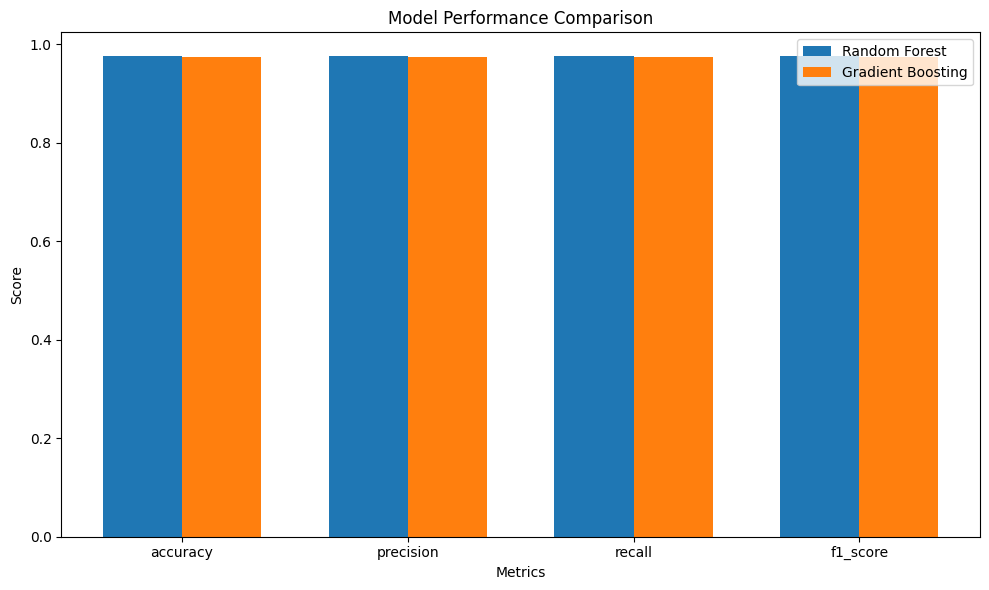

In [194]:
compare_models(rf_metrics, gb_metrics)